In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

from scipy.stats import spearmanr, chi2_contingency
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, plot_precision_recall_curve, plot_roc_curve

import tensorflow as tf
from tensorflow import keras

In [2]:
pd.options.display.max_columns = None

## Example - Telco Churn
### Load Data

In [3]:
df = pd.read_csv('../../Github/python-data-science/data/telco-customer-churn.csv')
df.shape

(7032, 21)

In [4]:
df.columns = [c[0].upper() + c[1:] for c in df.columns]

In [5]:
df.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        7032 non-null   object 
 1   Gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   Tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [7]:
# Reviewed before - (1) CustomerID is primary key, (2) Total Charges = Monthly Charges * tenure
df = df.drop(columns=['CustomerID', 'TotalCharges'])
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   Tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 


In [9]:
df.select_dtypes(object).apply(pd.Series.unique)

Gender                                                 [Female, Male]
Partner                                                     [Yes, No]
Dependents                                                  [No, Yes]
PhoneService                                                [No, Yes]
MultipleLines                             [No phone service, No, Yes]
InternetService                                [DSL, Fiber optic, No]
OnlineSecurity                         [No, Yes, No internet service]
OnlineBackup                           [Yes, No, No internet service]
DeviceProtection                       [No, Yes, No internet service]
TechSupport                            [No, Yes, No internet service]
StreamingTV                            [No, Yes, No internet service]
StreamingMovies                        [No, Yes, No internet service]
Contract                         [Month-to-month, One year, Two year]
PaperlessBilling                                            [Yes, No]
PaymentMethod       

In [10]:
df.select_dtypes(object).apply(pd.Series.value_counts).\
reindex(['Female', 'Male',
         'Yes', 'No',
         'DSL','Fiber optic','No internet service','No phone service',
         'Month-to-month', 'One year', 'Two year',
         'Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check',  'Mailed check'])

,Gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
Female,3483.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Male,3549.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yes,NaN,3393.0,2099.0,6352.0,2967.0,NaN,2015.0,2425.0,2418.0,2040.0,2703.0,2731.0,NaN,4168.0,NaN
No,NaN,3639.0,4933.0,680.0,3385.0,1520.0,3497.0,3087.0,3094.0,3472.0,2809.0,2781.0,NaN,2864.0,NaN
DSL,NaN,NaN,NaN,NaN,NaN,2416.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fiber optic,NaN,NaN,NaN,NaN,NaN,3096.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
No internet service,NaN,NaN,NaN,NaN,NaN,NaN,1520.0,1520.0,1520.0,1520.0,1520.0,1520.0,NaN,NaN,NaN
No phone service,NaN,NaN,NaN,NaN,680.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Month-to-month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3875.0,NaN,NaN
One year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1472.0,NaN,NaN


In [11]:
df.replace('No internet service', 'No', inplace=True)
df.replace('No phone service', 'No', inplace=True)

In [12]:
df.select_dtypes(object).apply(pd.Series.unique)

Gender                                                 [Female, Male]
Partner                                                     [Yes, No]
Dependents                                                  [No, Yes]
PhoneService                                                [No, Yes]
MultipleLines                                               [No, Yes]
InternetService                                [DSL, Fiber optic, No]
OnlineSecurity                                              [No, Yes]
OnlineBackup                                                [Yes, No]
DeviceProtection                                            [No, Yes]
TechSupport                                                 [No, Yes]
StreamingTV                                                 [No, Yes]
StreamingMovies                                             [No, Yes]
Contract                         [Month-to-month, One year, Two year]
PaperlessBilling                                            [Yes, No]
PaymentMethod       

### Weight of Evidence + Information Value + Effect Size (CramersV)

In [13]:
# https://towardsdatascience.com/churn-analysis-information-value-and-weight-of-evidence-6a35db8b9ec5

def plot_woe(res, x, iv_dict, pv_dict, cv_dict):
    '''
    Positive WOE implies higher probability of event 1 vs. 0
    Negative WOE — the opposite.
    '''
    res.columns = ['count', 'ones']
    total_count, total_ones = res.sum()
    total_zeros = total_count - total_ones
    res['zeros'] = res['count'] - res['ones']
    res['zeros_pct'] = res['zeros']/total_zeros
    res['ones_pct']  = res['ones']/total_ones
    
    # Calculating WOE & Information Value
    res['woe'] = np.log(res['ones_pct']/res['zeros_pct'])
    res['iv']  = res['woe']*(res['ones_pct'] - res['zeros_pct'])
    
    # Calculating other statistics
    chi = chi2_contingency(np.array(res[['zeros', 'ones']]))
    n   = res['count'].sum()
    cv  = np.sqrt(chi[0]/n)
    
    # Updating dicts
    iv_dict[x] = res['iv'].sum()
    pv_dict[x] = chi[1]
    cv_dict[x] = cv
    
    sns.barplot(data=res, x=list(res.index), y='woe', color='grey').set_xlabel(x)
    plt.xticks(rotation=45)
    return iv_dict, pv_dict, cv_dict


def calculate_woe(dataframe, feats, label, ncol=3):
    '''
    df: dataframe
    feats: variable of interest
    label: output variable
    '''
    n, rows, cols = len(feats), int(np.ceil(len(feats)/ncol)), ncol
    plt.figure(figsize=(15, 5*rows))
    df = dataframe[feats+[label]].copy()
    iv_dict  = dict()      #information value
    pv_dict = dict()       #p-value
    cv_dict  = dict()      #cramers_v value
    
    for i, x in enumerate(feats):

        # Categorical feature
        if df[x].dtype == object:
            res = df[[x,label]].groupby(by=x).agg(['count', 'sum'])
            plt.subplot(rows, cols, i+1)
            iv_dict, pv_dict, cv_dict = plot_woe(res, x, iv_dict, pv_dict, cv_dict)

        # Numeric feature - try binning
        else:
            for bins_num in range(20, 1, -1):
                df['bin'] = pd.qcut(df[x], bins_num, duplicates='drop').apply(lambda x: x.right).astype(float)
                df_grouped = pd.DataFrame(df.groupby('bin').agg({x:'count', label: 'sum'})).reset_index()
                r = abs(spearmanr(df_grouped['bin'], df_grouped[label]/df_grouped[x])[0]) #/df[x] because of uneven size

                if (
                    r==1
                    and df_grouped[x].min() > .05*df_grouped[x].sum() # minimum 5% in each bucket
                    and not (df_grouped[x] == df_grouped[label]).any() # contains both events/ non-events
                    ):
                    break

            # df['bin'] = df['bin'].fillna(999) # to include NaN in output
            res = df[['bin',label]].groupby(by='bin').agg(['count', 'sum'])
            plt.subplot(rows, cols, i+1)
            iv_dict, pv_dict, cv_dict = plot_woe(res, x, iv_dict, pv_dict, cv_dict)
    plt.tight_layout()
    
    return iv_dict, pv_dict, cv_dict

In [14]:
feats = df.columns[:-1].tolist()
feats.sort()

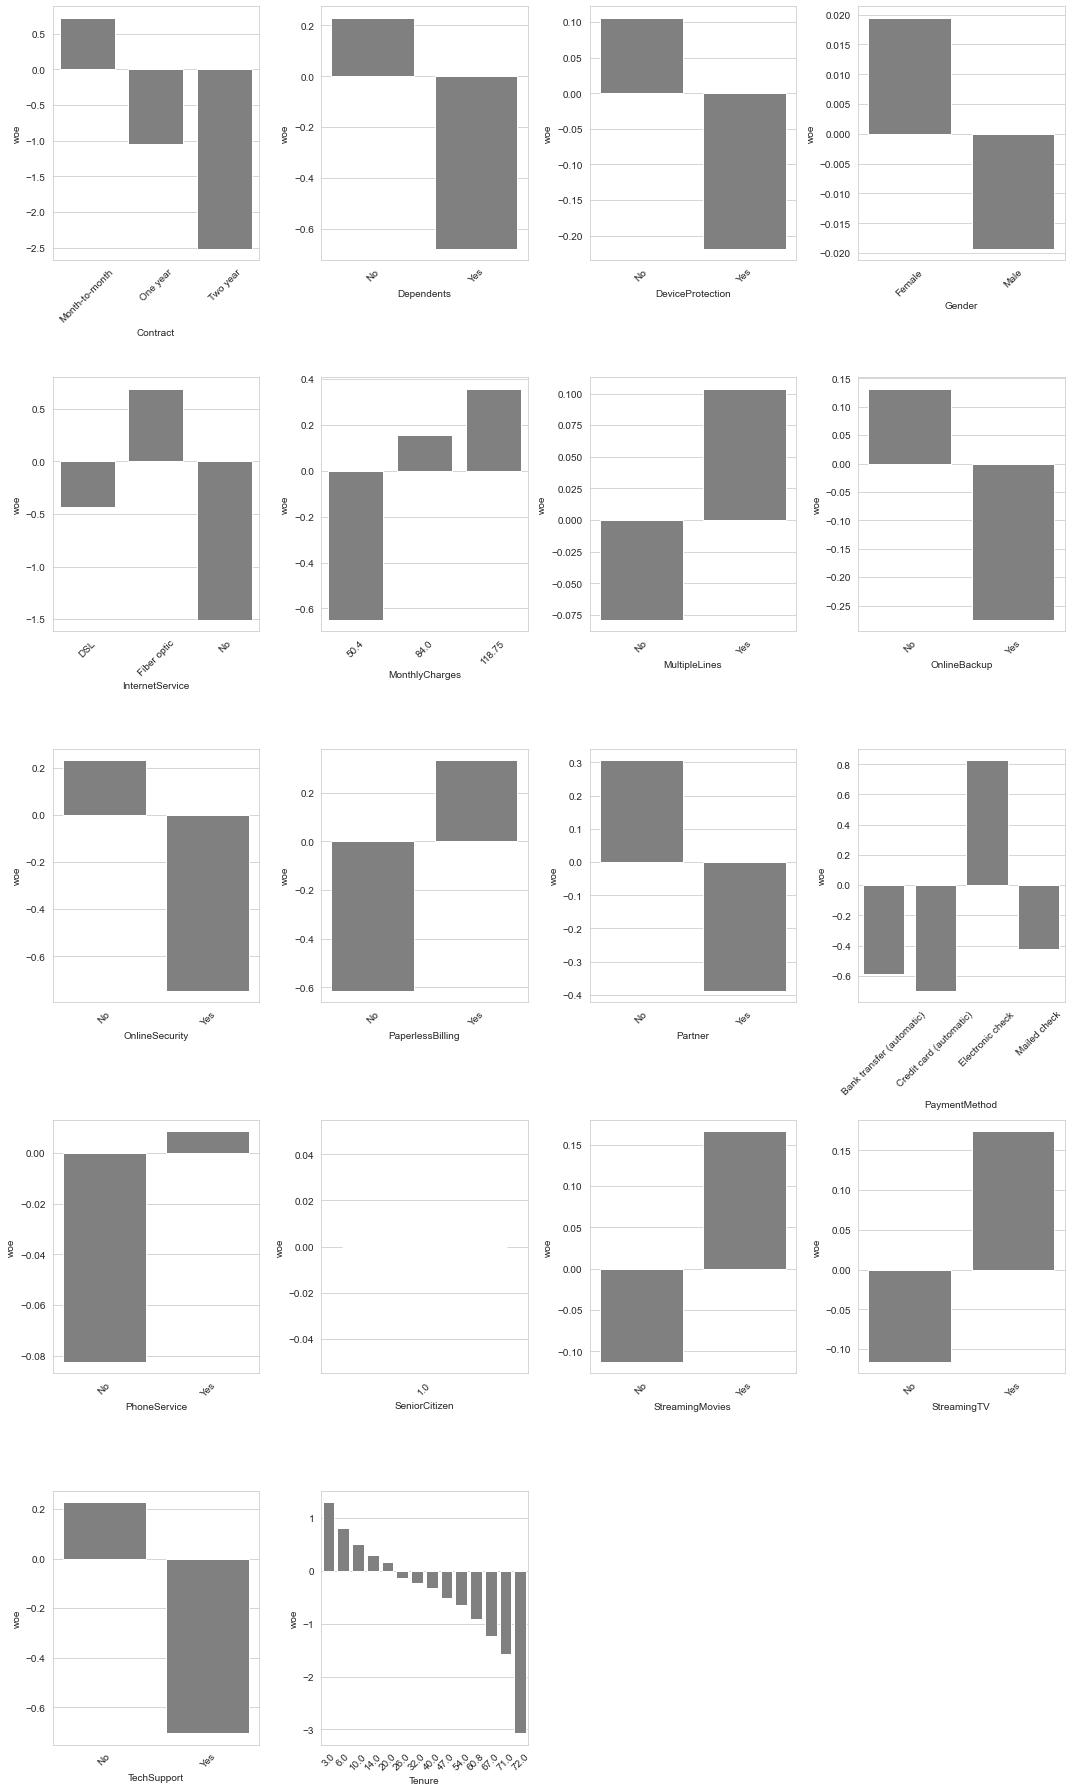

In [15]:
iv, pv, cramers_v = calculate_woe(df, feats, 'Churn', ncol=4)

#### **Some factors contributing to customer churning?**
* Contract type of month-to-month
* Tenure of <12 months
* Monthly charges of >$50
* Payment method of 'electronic check'
* No tech support

In [16]:
def interpret_iv(x):
    if x<0.02:  return 'useless'
    elif x<0.1: return 'weak'
    elif x<0.3: return 'medium'
    elif x<0.5: return 'strong'
    else:       return 'very strong/suspicious'

In [17]:
def interpret_cv(x):
    if   x<0.1: return 'useless'
    elif x<0.2: return 'weak'
    elif x<0.4: return 'medium'
    elif x<0.6: return 'strong'
    else:       return 'very strong/suspicious'

In [18]:
IV = pd.DataFrame(index=iv.keys(), data=iv.values())
IV.columns = ['Information_Value']
IV.sort_values(by='Information_Value', inplace=True, ascending=False)
IV['IV_Interpret'] = IV['Information_Value'].apply(interpret_iv)
IV

,Information_Value,IV_Interpret
Contract,1.233189,very strong/suspicious
Tenure,0.855756,very strong/suspicious
InternetService,0.615253,very strong/suspicious
PaymentMethod,0.455756,strong
PaperlessBilling,0.202056,medium
MonthlyCharges,0.172516,medium
OnlineSecurity,0.171862,medium
TechSupport,0.157353,medium
Dependents,0.153169,medium
Partner,0.117877,medium


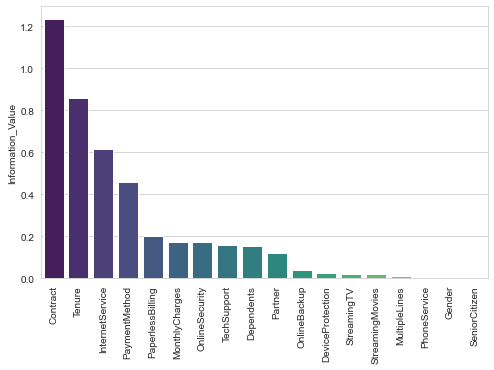

In [19]:
plt.figure(figsize=(8,5))
sns.barplot(x=IV.index, y=IV['Information_Value'], palette='viridis')
plt.xticks(rotation=90);

In [20]:
PV = pd.DataFrame(index=pv.keys(), data=pv.values())
PV.columns = ['P_value']
PV['P_value'] = PV['P_value'].round(2)
# PV

In [21]:
CV = pd.DataFrame(index=cramers_v.keys(), data=cramers_v.values())
CV.columns = ['CramersV']
CV['CramersV'] = CV['CramersV'].round(2)
# CV

In [22]:
res = pd.concat([IV, PV, CV], axis=1)
res['CV_Interpret'] = res['CramersV'].apply(interpret_cv)
res

,Information_Value,IV_Interpret,P_value,CramersV,CV_Interpret
Contract,1.233189,very strong/suspicious,0.00,0.41,strong
Tenure,0.855756,very strong/suspicious,0.00,0.38,medium
InternetService,0.615253,very strong/suspicious,0.00,0.32,medium
PaymentMethod,0.455756,strong,0.00,0.30,medium
PaperlessBilling,0.202056,medium,0.00,0.19,weak
MonthlyCharges,0.172516,medium,0.00,0.18,weak
OnlineSecurity,0.171862,medium,0.00,0.17,weak
TechSupport,0.157353,medium,0.00,0.16,weak
Dependents,0.153169,medium,0.00,0.16,weak
Partner,0.117877,medium,0.00,0.15,weak


### Data Prep for Modeling

In [23]:
df.select_dtypes(object).apply(pd.Series.unique)

Gender                                                 [Female, Male]
Partner                                                     [Yes, No]
Dependents                                                  [No, Yes]
PhoneService                                                [No, Yes]
MultipleLines                                               [No, Yes]
InternetService                                [DSL, Fiber optic, No]
OnlineSecurity                                              [No, Yes]
OnlineBackup                                                [Yes, No]
DeviceProtection                                            [No, Yes]
TechSupport                                                 [No, Yes]
StreamingTV                                                 [No, Yes]
StreamingMovies                                             [No, Yes]
Contract                         [Month-to-month, One year, Two year]
PaperlessBilling                                            [Yes, No]
PaymentMethod       

In [24]:
cols_yn = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines',
           'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
           'StreamingTV', 'StreamingMovies', 'PaperlessBilling']

In [25]:
for col in cols_yn:
    df[col] = df.loc[:,col].replace({'Yes':1, 'No':0})

In [26]:
df.apply(pd.Series.unique)

Gender                                                 [Female, Male]
SeniorCitizen                                                  [0, 1]
Partner                                                        [1, 0]
Dependents                                                     [0, 1]
Tenure              [1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...
PhoneService                                                   [0, 1]
MultipleLines                                                  [0, 1]
InternetService                                [DSL, Fiber optic, No]
OnlineSecurity                                                 [0, 1]
OnlineBackup                                                   [1, 0]
DeviceProtection                                               [0, 1]
TechSupport                                                    [0, 1]
StreamingTV                                                    [0, 1]
StreamingMovies                                                [0, 1]
Contract            

In [27]:
df['Gender'] = df.loc[:,'Gender'].replace({'Female':1, 'Male':0})

In [28]:
cols_dummy = ['InternetService', 'Contract', 'PaymentMethod']
df_clean = pd.get_dummies(df, columns=cols_dummy) #, drop_first=True)
df_clean.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,Churn,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,29.85,0,1,0,0,1,0,0,0,0,1,0
1,0,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,0,1,0,0,0,1,0,0,0,0,1
2,0,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,1,1,0,0,1,0,0,0,0,0,1
3,0,0,0,0,45,0,0,1,0,1,1,0,0,0,42.30,0,1,0,0,0,1,0,1,0,0,0
4,1,0,0,0,2,1,0,0,0,0,0,0,0,1,70.70,1,0,1,0,1,0,0,0,0,1,0


In [29]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Gender                                   7032 non-null   int64  
 1   SeniorCitizen                            7032 non-null   int64  
 2   Partner                                  7032 non-null   int64  
 3   Dependents                               7032 non-null   int64  
 4   Tenure                                   7032 non-null   int64  
 5   PhoneService                             7032 non-null   int64  
 6   MultipleLines                            7032 non-null   int64  
 7   OnlineSecurity                           7032 non-null   int64  
 8   OnlineBackup                             7032 non-null   int64  
 9   DeviceProtection                         7032 non-null   int64  
 10  TechSupport                              7032 no

In [30]:
cols_to_scale = ['Tenure', 'MonthlyCharges']

sc = MinMaxScaler()
df_clean[cols_to_scale] = sc.fit_transform(df_clean[cols_to_scale])

In [31]:
df_clean.agg(['min', 'max'])

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,Churn,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
min,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0
max,1,1,1,1,1.0,1,1,1,1,1,1,1,1,1,1.0,1,1,1,1,1,1,1,1,1,1,1


### Modeling

In [32]:
X = df_clean.drop(columns='Churn')
y = df_clean['Churn']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
print(X_train.shape, X_test.shape)

(5625, 25) (1407, 25)


In [34]:
model = keras.Sequential([
    keras.layers.Dense(25, input_shape=(25,), activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100)

Epoch 1/100
176/176 [==============================] - 0s 872us/step - loss: 0.5511 - accuracy: 0.7186
Epoch 2/100
176/176 [==============================] - 0s 769us/step - loss: 0.4370 - accuracy: 0.7899
Epoch 3/100
176/176 [==============================] - 0s 815us/step - loss: 0.4228 - accuracy: 0.7991
Epoch 4/100
176/176 [==============================] - 0s 769us/step - loss: 0.4181 - accuracy: 0.7991
Epoch 5/100
176/176 [==============================] - 0s 684us/step - loss: 0.4145 - accuracy: 0.8004
Epoch 6/100
176/176 [==============================] - 0s 781us/step - loss: 0.4120 - accuracy: 0.8037
Epoch 7/100
176/176 [==============================] - 0s 644us/step - loss: 0.4101 - accuracy: 0.8036
Epoch 8/100
176/176 [==============================] - 0s 786us/step - loss: 0.4077 - accuracy: 0.8059
Epoch 9/100
176/176 [==============================] - 0s 735us/step - loss: 0.4067 - accuracy: 0.8073
Epoch 10/100
176/176 [==============================] - 0s 718us/step - l

176/176 [==============================] - 0s 913us/step - loss: 0.3604 - accuracy: 0.8304
Epoch 81/100
176/176 [==============================] - 0s 1ms/step - loss: 0.3603 - accuracy: 0.8293
Epoch 82/100
176/176 [==============================] - 0s 918us/step - loss: 0.3598 - accuracy: 0.8277
Epoch 83/100
176/176 [==============================] - 0s 855us/step - loss: 0.3587 - accuracy: 0.8295
Epoch 84/100
176/176 [==============================] - 0s 1ms/step - loss: 0.3586 - accuracy: 0.8313
Epoch 85/100
176/176 [==============================] - 0s 1ms/step - loss: 0.3588 - accuracy: 0.8308
Epoch 86/100
176/176 [==============================] - 0s 1ms/step - loss: 0.3580 - accuracy: 0.8272
Epoch 87/100
176/176 [==============================] - 0s 1ms/step - loss: 0.3576 - accuracy: 0.8313
Epoch 88/100
176/176 [==============================] - 0s 889us/step - loss: 0.3582 - accuracy: 0.8297
Epoch 89/100
176/176 [==============================] - 0s 821us/step - loss: 0.3569 - 

In [35]:
y_pred = model.predict(X_test)
y_pred[0:5]

array([[0.10395825],
       [0.5542437 ],
       [0.00575605],
       [0.63860714],
       [0.45085475]], dtype=float32)

In [36]:
y_pred = y_pred[:,0]
y_pred[0:5]

array([0.10395825, 0.5542437 , 0.00575605, 0.63860714, 0.45085475],
      dtype=float32)

In [37]:
y_pred_class = (y_pred > 0.5).astype(int)
y_pred_class[0:5]

array([0, 1, 0, 1, 0])

In [38]:
print(confusion_matrix(y_test, y_pred_class))

[[886 113]
 [198 210]]


In [39]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       999
           1       0.65      0.51      0.57       408

    accuracy                           0.78      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.77      0.78      0.77      1407

